In [442]:
# number of neurons in the hidden layer
hidden_dim = 2000

# learning rate
learning_rate = 0.005

# number of training epochs
n_epochs = 10

# percentage of training data used for validation
val_size = 0.1

In [443]:
import numpy as np
import csv
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

path_train = 'mnist_train.csv'
path_test = 'mnist_test.csv'

def readCsv(path):
    with open(path, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in reader:
            j = len(row)
            i = i+1
        A = np.zeros((i,j), dtype=np.int_)
    
    with open(path, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in reader:
            j = 0
            for x in row:
                A[i,j] = int(x)
                j = j+1
            i = i+1
    return A

train_data = readCsv(path_train)
test_data = readCsv(path_test)

train_images = train_data[:,1:]
train_labels = train_data[:,0]
test_images = test_data[:,1:]
test_labels = test_data[:,0]

print(train_images.shape, train_labels.shape)

(60000, 784) (60000,)


In [444]:
n = len(train_images)
x = int(n*(1-val_size))
t_images = train_images[:x]
t_labels = train_labels[:x]
v_images = train_images[x:]
v_labels = train_labels[x:]

In [445]:
class DigitDataset(Dataset):
    def __init__(self, features, labels):
        super(DigitDataset, self).__init__()
        self.features = features
        self.labels = labels
        self.transforms = transforms.Compose([transforms.ToTensor()])
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        image = self.features[index,:]
        image = image.reshape(28,28,1)
        image = self.transforms(image)
        image = image.float()
        label = self.labels[index]
        label = label.astype(np.int64)
        return (image, label)

train_dataset = DigitDataset(t_images, t_labels)
val_dataset = DigitDataset(v_images, v_labels)
test_dataset = DigitDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [446]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.main = nn.Sequential(nn.Linear(28*28, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, 10))
    
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.main(out)
        return out

In [452]:
model = MLPModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [453]:
def train():
    model.train()
    train_loss = 0
    for iteration, (images, labels) in enumerate(train_loader):
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = train_loss / len(train_loader)
    return average_loss

def validation():
    model.eval()
    val_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            loss = loss_fn(output, labels)
            val_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()
            
    accuracy = 100.0 * n_correct / len(val_loader.dataset)
    average_loss = val_loss / len(val_loader)
    return val_loss, accuracy

def test():
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()
            
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    average_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [454]:
train_losses = []
val_losses = []
val_accuracy = []
for epoch in range(n_epochs):
    train_loss = train()
    train_losses.append(train_loss)
    val_loss, accuracy = validation()
    val_losses.append(val_loss)
    val_accuracy.append(accuracy)
    print('Epoch {}, Training loss: {:.4f}, Validation loss: {:.4f}, Validation accuracy: {:.1f}%'.format(epoch+1, train_loss, val_loss, accuracy))

Epoch 1, Training loss: 2.3841, Validation loss: 16.4871, Validation accuracy: 95.4%
Epoch 2, Training loss: 0.1138, Validation loss: 15.2792, Validation accuracy: 95.7%
Epoch 3, Training loss: 0.0692, Validation loss: 12.2164, Validation accuracy: 97.0%
Epoch 4, Training loss: 0.0434, Validation loss: 12.6978, Validation accuracy: 97.2%
Epoch 5, Training loss: 0.0308, Validation loss: 13.6371, Validation accuracy: 97.2%
Epoch 6, Training loss: 0.0232, Validation loss: 13.9254, Validation accuracy: 97.3%
Epoch 7, Training loss: 0.0144, Validation loss: 11.4622, Validation accuracy: 97.7%
Epoch 8, Training loss: 0.0096, Validation loss: 13.3391, Validation accuracy: 97.5%
Epoch 9, Training loss: 0.0051, Validation loss: 11.7425, Validation accuracy: 97.7%
Epoch 10, Training loss: 0.0034, Validation loss: 12.3378, Validation accuracy: 97.8%


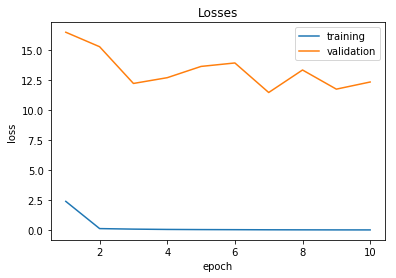

In [455]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.plot(np.arange(1, n_epochs+1), train_losses)
plt.plot(np.arange(1, n_epochs+1), val_losses)
plt.legend(['training', 'validation'])

In [456]:
test_loss, accuracy = test()
print('Test loss: {:.4f}, accuracy: {:.1f}%'.format(test_loss, accuracy))

Test loss: 19.0325, accuracy: 97.9%
